Generate Paired Data for Denoising

In [ ]:
import os
import numpy as np
from PIL import Image
import random

def add_noise(image, noise_level=25):
    """
    Adds Gaussian noise to an image.
    Args:
        image (PIL.Image): Input image.
        noise_level (int): Standard deviation of the Gaussian noise.
    Returns:
        PIL.Image: Noisy image.
    """
    np_image = np.array(image).astype(np.float32)
    noise = np.random.normal(0, noise_level, np_image.shape)
    noisy_image = np_image + noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_image)

# Directories for saving
os.makedirs('./paired_data/input', exist_ok=True)
os.makedirs('./paired_data/target', exist_ok=True)

# Generate paired data
data_dir = './clean_images'  # Replace with the directory of your clean images
for i, file_name in enumerate(os.listdir(data_dir)):
    image_path = os.path.join(data_dir, file_name)
    image = Image.open(image_path).convert("RGB")

    noisy_image = add_noise(image, noise_level=random.randint(15, 50))  # Add random noise level

    noisy_image.save(f'./paired_data/input/noisy_{i}.jpg')
    image.save(f'./paired_data/target/clean_{i}.jpg')

print("Paired noisy-clean dataset created!")


Upload and Prepare Dataset

In [1]:
import zipfile
import os

# Path to zip file
zip_path = "/content/paired_data.zip"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('./paired_data')

# Verify dataset structure
print("Dataset structure:")
for root, dirs, files in os.walk('./paired_data'):
    print(root, len(files), "files")


Dataset structure:
./paired_data 0 files
./paired_data/paired_data 0 files
./paired_data/paired_data/target 6 files
./paired_data/paired_data/input 6 files


In [2]:
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Custom Dataset class for paired images
class PairedImageDataset(Dataset):
    def __init__(self, input_dir, target_dir, transform=None):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.input_files = sorted(os.listdir(input_dir))
        self.target_files = sorted(os.listdir(target_dir))
        self.transform = transform

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_dir, self.input_files[idx])
        target_path = os.path.join(self.target_dir, self.target_files[idx])
        input_image = Image.open(input_path).convert("RGB")
        target_image = Image.open(target_path).convert("RGB")

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image

# Define preprocessing
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Create dataset and dataloader
input_dir = './paired_data/paired_data/input'
target_dir = './paired_data/paired_data/target'
dataset = PairedImageDataset(input_dir, target_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Test the dataloader
for input_images, target_images in dataloader:
    print("Input batch shape:", input_images.shape)
    print("Target batch shape:", target_images.shape)
    break


Input batch shape: torch.Size([1, 3, 512, 512])
Target batch shape: torch.Size([1, 3, 512, 512])


In [3]:
import torch
from diffusers import StableDiffusionImg2ImgPipeline

# Load pre-trained Stable Diffusion model
MODEL_NAME = "runwayml/stable-diffusion-v1-5"
pipeline = StableDiffusionImg2ImgPipeline.from_pretrained(
    MODEL_NAME, torch_dtype=torch.float16
).to("cuda")

print("Stable Diffusion model loaded successfully!")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Stable Diffusion model loaded successfully!


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.amp import GradScaler, autocast
from torchvision import transforms
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import StableDiffusionPipeline
from torchvision import transforms
from PIL import Image

# Initialize tokenizer and text encoder
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to("cuda")

# Data Augmentation
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

def fine_tune_model(dataloader, pipeline, epochs=2, accumulation_steps=2):
    pipeline.unet.train()
    optimizer = optim.AdamW(pipeline.unet.parameters(), lr=5e-6)

    for epoch in range(epochs):
        total_loss = 0
        for step, (input_images, target_images) in enumerate(dataloader):
            # Move images to float16 and normalize to [-1, 1]
            input_images = input_images.to("cuda", dtype=torch.float16) * 2 - 1
            target_images = target_images.to("cuda", dtype=torch.float16) * 2 - 1

            # Encode images into latent space
            latents_input = pipeline.vae.encode(input_images).latent_dist.sample() * 0.18215
            latents_target = pipeline.vae.encode(target_images).latent_dist.sample() * 0.18215

            # Generate text embeddings for "person's description"
            text_inputs = tokenizer(["a portrait of a young man"] * len(input_images),
                                     padding="max_length",
                                     max_length=77,
                                     truncation=True,
                                     return_tensors="pt").to("cuda")
            encoder_hidden_states = text_encoder(text_inputs.input_ids)[0].to(dtype=torch.float16)

            # Add noise to latent space
            noise = torch.randn_like(latents_input, dtype=torch.float16)
            timesteps = torch.randint(0, 1000, (latents_input.size(0),), device=latents_input.device).long()
            noisy_latents = pipeline.scheduler.add_noise(latents_input, noise, timesteps)

            # Predict noise and calculate loss
            with autocast(device_type="cuda"):
                noise_pred = pipeline.unet(noisy_latents, timesteps, encoder_hidden_states=encoder_hidden_states).sample
                loss = F.mse_loss(noise_pred, noise) / accumulation_steps

            # Backpropagation
            loss.backward()
            total_loss += loss.item()

            if (step + 1) % accumulation_steps == 0 or (step + 1) == len(dataloader):
                torch.nn.utils.clip_grad_norm_(pipeline.unet.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")
        pipeline.unet.save_pretrained(f"./fine_tuned_unet_epoch_{epoch + 1}")

# Fine-tune the model
fine_tune_model(dataloader, pipeline, epochs=18, accumulation_steps=2)

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Epoch 1/2, Loss: nan
Epoch 2/2, Loss: nan


In [5]:
!nvidia-smi

Wed Dec  4 17:24:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0              29W /  70W |  14201MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
import torch
torch.cuda.empty_cache()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

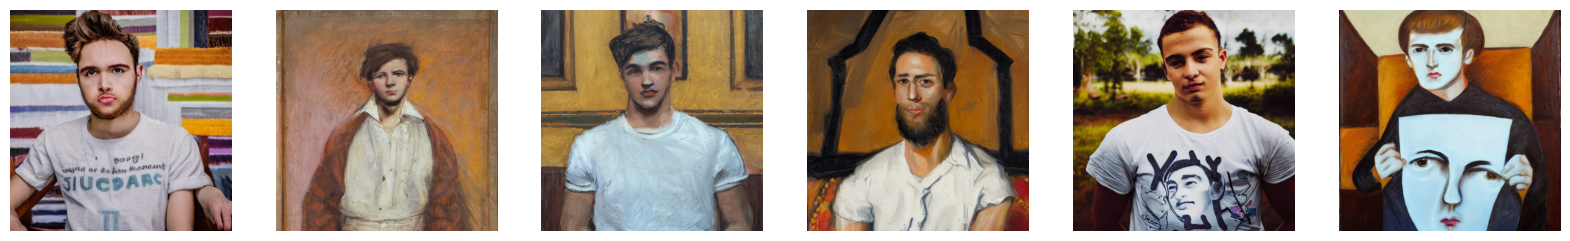

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
from diffusers import StableDiffusionImg2ImgPipeline
import torch

# Initialize pipeline
pipeline = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16
).to("cuda")

def test_model_variation(pipeline, test_images, prompt="a portrait of a young man", strength=0.8):
    generated_images = []
    for test_image_path in test_images:
        image = Image.open(test_image_path).convert("RGB")
        image = image.resize((512, 512))

        # Run inference
        result = pipeline(
            prompt=prompt,
            image=image,
            strength=strength,
            guidance_scale=7.5,
            num_inference_steps=50,
            eta=0.0
        )

        generated_images.append(result.images[0])

    return generated_images

# Test with six images
test_images = [
    "./paired_data/paired_data/input/noisy_0.jpg",
    "./paired_data/paired_data/input/noisy_1.jpg",
    "./paired_data/paired_data/input/noisy_2.jpg",
    "./paired_data/paired_data/input/noisy_3.jpg",
    "./paired_data/paired_data/input/noisy_4.jpg",
    "./paired_data/paired_data/input/noisy_5.jpg",
]
output_images = test_model_variation(pipeline, test_images, prompt="a creative portrait of a young man")

# Display the generated images
fig, axes = plt.subplots(1, len(output_images), figsize=(20, 5))
for i, img in enumerate(output_images):
    axes[i].imshow(img)
    axes[i].axis("off")
plt.show()

